# Loading Libraries

In [56]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os
import random

from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

# Download DataSet Using Kaggle Api

In [3]:
!pip install kaggle

In [4]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0


In [6]:
!unzip brain-tumor-mri-dataset

Streaming output truncated to the last 5000 lines.
  inflating: Training/glioma/Tr-gl_0712.jpg  
  inflating: Training/glioma/Tr-gl_0713.jpg  
  inflating: Training/glioma/Tr-gl_0714.jpg  
  inflating: Training/glioma/Tr-gl_0715.jpg  
  inflating: Training/glioma/Tr-gl_0716.jpg  
  inflating: Training/glioma/Tr-gl_0717.jpg  
  inflating: Training/glioma/Tr-gl_0718.jpg  
  inflating: Training/glioma/Tr-gl_0719.jpg  
  inflating: Training/glioma/Tr-gl_0720.jpg  
  inflating: Training/glioma/Tr-gl_0721.jpg  
  inflating: Training/glioma/Tr-gl_0722.jpg  
  inflating: Training/glioma/Tr-gl_0723.jpg  
  inflating: Training/glioma/Tr-gl_0724.jpg  
  inflating: Training/glioma/Tr-gl_0725.jpg  
  inflating: Training/glioma/Tr-gl_0726.jpg  
  inflating: Training/glioma/Tr-gl_0727.jpg  
  inflating: Training/glioma/Tr-gl_0728.jpg  
  inflating: Training/glioma/Tr-gl_0729.jpg  
  inflating: Training/glioma/Tr-gl_0730.jpg  
  inflating: Training/glioma/Tr-gl_0731.jpg  
  inflating: Training/glioma/

# Loading Data Into Data Frames

In [7]:
train_dir = '/content/Training'
test_dir = '/content/Testing'

In [8]:
IMAGE_SIZE = 224
BATCH_SIZE = 32

In [9]:
def load_dataset(dir,batch_size, img_size):
  dataset = image_dataset_from_directory(
        dir,
        shuffle=True,
        image_size=img_size,
        batch_size=batch_size
    )
  return dataset

In [10]:
train_dataset = load_dataset(train_dir, BATCH_SIZE, (IMAGE_SIZE, IMAGE_SIZE))

Found 5712 files belonging to 4 classes.


In [11]:
test_dataset = load_dataset(test_dir, BATCH_SIZE, (IMAGE_SIZE, IMAGE_SIZE))

Found 1311 files belonging to 4 classes.


In [12]:
train_dataset.class_names

['glioma', 'meningioma', 'notumor', 'pituitary']

# Data Visualization

<Figure size 1000x1000 with 0 Axes>

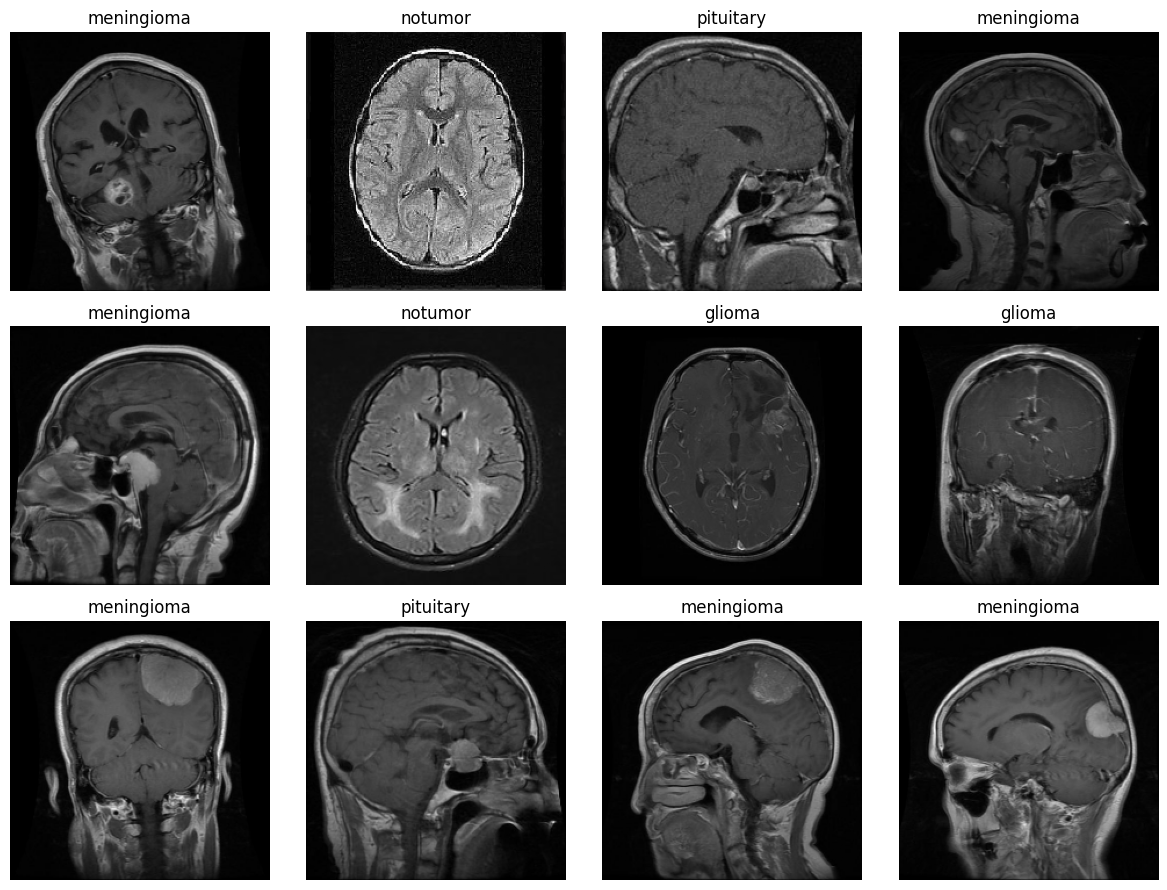

In [77]:
def plot_images(dataset, num_images=12):
    class_names = dataset.class_names
    plt.figure(figsize=(10, 10))

    for images, labels in dataset.take(1):
        images, labels = images.numpy() / 255.0, labels.numpy()
        fig, axes = plt.subplots(3, 4, figsize=(12, 9))
        axes = axes.ravel()

        for i in range(num_images):
            axes[i].imshow(images[i])
            axes[i].set_title(class_names[labels[i]])
            axes[i].axis("off")

        plt.tight_layout()
        plt.show()
        break

plot_images(train_dataset)

# Applying Data Augmentation

In [14]:
def augmented_data(dataset):
    augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomBrightness(0.2),
        tf.keras.layers.RandomContrast(0.2),
        tf.keras.layers.Rescaling(1./255)
    ])

    return dataset.map(lambda x, y: (augmentation(x, training=True), y))

In [15]:
aug_train = augmented_data(train_dataset)

In [16]:
aug_test = augmented_data(test_dataset)

In [17]:
augmented_img = aug_train.take(2).as_numpy_iterator().next()

In [18]:
augmented_img[0][5].max()

np.float32(1.0)

# Plotting Augmented Images

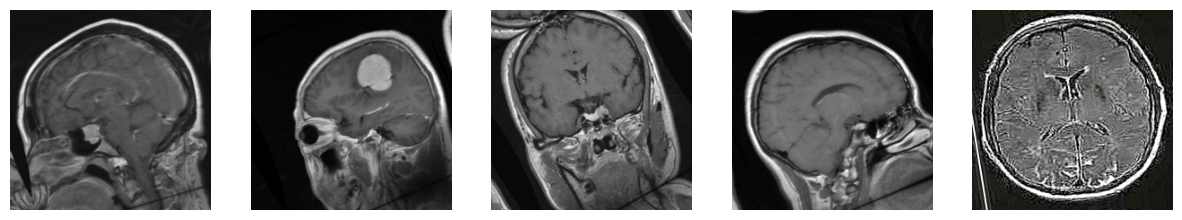

In [19]:
num_images = 5
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

for i in range(num_images):
    image = augmented_img[0][i]
    axes[i].imshow(image)
    axes[i].axis('off')

plt.show()

# Splitting Test DataSet Into Validation

In [38]:
total_batches = tf.data.experimental.cardinality(aug_test).numpy()

val_batches = int(0.8 * total_batches)

aug_val = aug_test.take(val_batches)
aug_test = aug_test.skip(val_batches)

print(f"Validation Set Batches: {tf.data.experimental.cardinality(aug_val).numpy()}")
print(f"Test Set Batches: {tf.data.experimental.cardinality(aug_test).numpy()}")


Validation Set Batches: 32
Test Set Batches: 9


# Model Building

## Using VGG16

In [20]:
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [21]:
for layer in base_model.layers:
    layer.trainable = False

In [22]:
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

## Fine Tunning

In [45]:
model = Sequential()
model.add(layers.Input(shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.BatchNormalization())
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(len(train_dataset.class_names), activation = 'softmax'))


In [46]:
model.compile(
    optimizer = Adam(learning_rate=0.0005),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['sparse_categorical_accuracy']
)

In [47]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,881,988 (56.77 MB)

 Trainable params: 7,245,444 (27.64 MB)

 Non-trainable params: 7,636,544 (29.13 MB)

In [48]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

In [49]:
history = model.fit(
    aug_train,
    validation_data=aug_val,
    epochs=5,
    callbacks=[lr_scheduler]
)

Epoch 1/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 90s 473ms/step - loss: 0.3475 - sparse_categorical_accuracy: 0.8664 - val_loss: 0.1799 - val_sparse_categorical_accuracy: 0.9531 - learning_rate: 5.0000e-04
Epoch 2/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 82s 456ms/step - loss: 0.1074 - sparse_categorical_accuracy: 0.9665 - val_loss: 0.0766 - val_sparse_categorical_accuracy: 0.9785 - learning_rate: 5.0000e-04
Epoch 3/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 80s 446ms/step - loss: 0.0731 - sparse_categorical_accuracy: 0.9774 - val_loss: 0.0884 - val_sparse_categorical_accuracy: 0.9678 - learning_rate: 5.0000e-04
Epoch 4/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 91s 496ms/step - loss: 0.0676 - sparse_categorical_accuracy: 0.9768 - val_loss: 0.1337 - val_sparse_categorical_accuracy: 0.9541 - learning_rate: 5.0000e-04
Epoch 5/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - loss: 0.0806 - sparse_categorical_accuracy: 0.9745
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
179/179 ━━━━━━━━━━━━━━━━━━━━ 135s 

# Visualizing Results

## Plots Train vs Validation

### Accuracy Plot

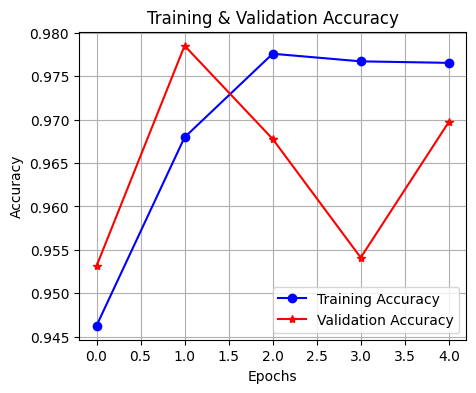

In [51]:
train_acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

plt.figure(figsize=(5, 4))
plt.plot(train_acc, 'bo-', label="Training Accuracy")
plt.plot(val_acc, 'r*-', label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

### Loss Plot

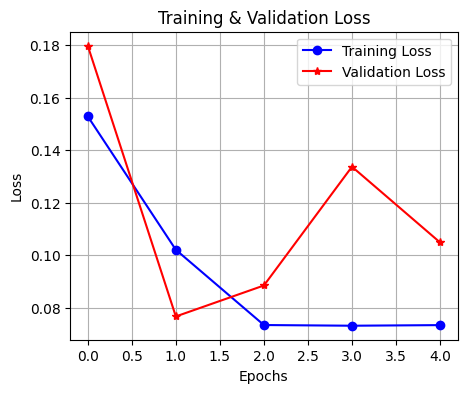

In [53]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(5, 4))
plt.plot(train_loss, 'bo-', label="Training Loss")
plt.plot(val_loss, 'r*-', label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# Predicting Result Using Test Dataset

## Classification Report

In [55]:
y_true = []
y_pred = []

for images, labels in aug_test:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print(classification_report(y_true, y_pred, target_names=train_dataset.class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 954ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
              precision    recall  f1-score   support

      glioma       1.00      0.96      0.98        77
  meningioma       0.92      1.00      0.96        59
     notumor       1.00      0.96      0.98        84
   pituitary       0.99      1.00      0.99        67

    accuracy                           0.98       287
   macro avg       0.98      0.98      0.98       287
weighted avg       0.98      0.98      0.98       287



# Confussion Matrix

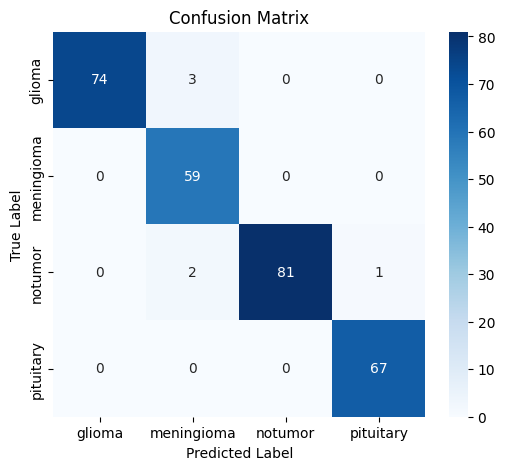

In [58]:
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=train_dataset.class_names,
            yticklabels=train_dataset.class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()